# How to define a machine

This tutorial shows the different ways to define electrical machine.

The notebook related to this tutorial is available on [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_Machine.ipynb).


### Type of machine Pyleecan can model
Pyleecan handles the geometrical modelling of main 2D radial flux machines such as:  
- surface or interior permanent magnet machines (SPMSM, IPMSM)  
- synchronous reluctance machines (SynRM)  
- squirrel-cage induction machines and doubly-fed induction machines (SCIM, DFIM)  
- would rotor synchronous machines and salient pole synchronous machines (WSRM)  
- switched reluctance machines (SRM)  

![](_static/machine_classes_UML.png)

There are two ways to create a machine in Pyleecan :  
- Graphical User Interface  
- Python script    

### Defining machine with Pyleecan GUI 
The GUI is the easiest way to define machine in Pyleecan. The interface enables to define in a user-friendly way every characteristics of the machine such as:  
- topology  
- dimensions  
- materials  
- winding  

 
![](_static/pyleecan_GUI.png)


#### Start the GUI
The GUI can be started by calling the script *pyleecan/run\_GUI.py* or by running the following cell in the notebook:


In [1]:
# Start Pyleecan GUI from this Jupyter Notebook
import subprocess

s=subprocess.run(['python','../run_GUI.py'])

#### Save and load a machine
The GUI enables to load and save every machine in the JSON format.

You can load machine saved with the pyleecan function *load*:

<IPython.core.display.Javascript object>


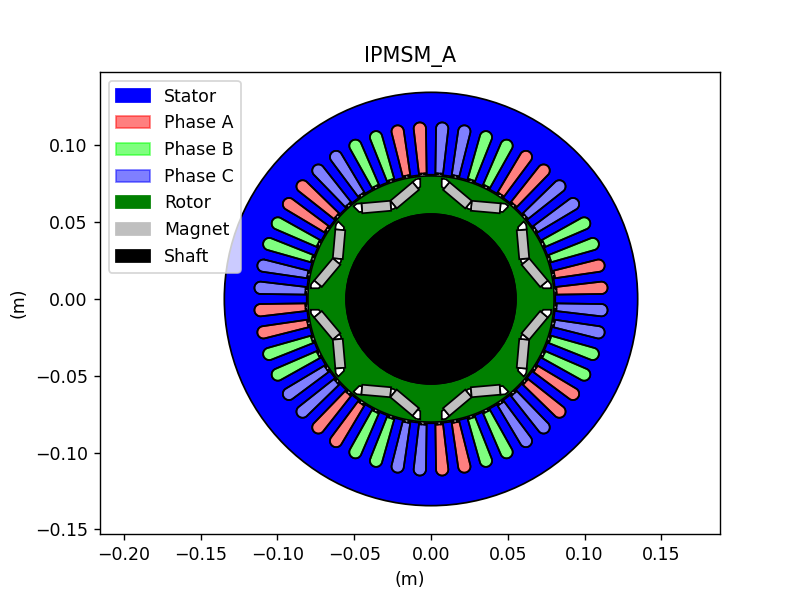

In [2]:
%matplotlib notebook

# Add pyleecan to the Python path
import sys
sys.path.append('../..')

# Import the function 
from pyleecan.Functions.load import load 

# Load and plot the machine
IPMSM_A = load('../Data/Machine/IPMSM_A.json')
im=IPMSM_A.plot()

### Defining Machine in scripting mode 
Pyleecan also enables to define the machine in scripting mode, using different classes.

Every rotor and stator can be created with the Lamination class or one of its daughters.  
![](_static/lamination_classes_UML.png)


#### Stator definition
To define the stator, we initialize a Lamination class with the different length.

In [3]:
from pyleecan.Classes.LamSlotWind import LamSlotWind
mm = 1e-3  # Millimeter


# Lamination setup
stator = LamSlotWind(
    Rint=160.4 * mm / 2, # internal radius [m]
    Rext=221.0 * mm / 2, # external radius [m]
    L1=70 * mm, # Lamination stack active length [m] without radial ventilation airducts 
                # but including insulation layers between lamination sheets
    Nrvd=0, # Number of radial air ventilation duct
    Kf1=1, # Lamination stacking / packing factor
    is_internal=False,
    is_stator=True, 
)

Then we add 48 slots using one of the Slot classes :

In [4]:
from pyleecan.Classes.SlotW21 import SlotW21

# Slot setup
stator.slot = SlotW21(
    Zs=48, # Slot number
    H0=1.0 * mm,  # Slot isthmus height
    H1=0.5 * mm, # Height
    H2=14.5 * mm, # Slot height below wedge 
    W0=2.0 * mm,  # Slot isthmus width
    W1=5 * mm, # Slot top width
    W2=7 * mm # Slot bottom width
)

Then we can define the winding and its conductor:

In [5]:
from pyleecan.Classes.WindingDW1L import WindingDW1L
from pyleecan.Classes.CondType12 import CondType12
# Winding setup
stator.winding = WindingDW1L(
    qs=3,  # number of phases
    Lewout=10 * mm,  # staight length of conductor outside lamination before EW-bend
    p=4,  # number of pole pairs
    Ntcoil=2,  # number of turns per coil
    Npcpp=1,  # number of parallel circuits per phase
    Nslot_shift_wind=0,  # 0 not to change the stator winding connection matrix built by pyleecan number 
                         # of slots to shift the coils obtained with pyleecan winding algorithm 
                         # (a, b, c becomes b, c, a with Nslot_shift_wind1=1)
)

# Conductor setup
stator.winding.conductor = CondType12(
    Wwire=1.0 * mm,  # single wire without isolation
    Wins_wire=0.1 * mm,  # single wire isolation thickness
    Wins_cond=1.3 * mm,  # winding coil isolation
    Nwppc=1,  # number of strands in parallel per coil
    Kwoh=1, # winding overhang factor which describes the fact that random round wire end-windings 
            # can be more or less compressed (0.5 for small motors, 0.8 for large motors) 
            # can be used to tune the average turn length (relevant if type_cond==1)
)

#### Rotor definition

For this example, we use the [LamHole](http://www.pyleecan.org/pyleecan.Classes.LamHole.html) class to define the rotor as a lamination with holes to contain magnet.

In the same way as for the stator, we start by defining the lamination:

In [6]:
from pyleecan.Classes.LamHole import LamHole

# Rotor setup
rotor = LamHole(
    Rint=59 * mm / 2, # Internal radius
    Rext=158 * mm / 2, # external radius
    is_internal=True, 
    is_stator=False,
    L1=stator.L1 # Stator
)

After that, we can add holes with magnets to the rotor using the class [HoleM50](http://www.pyleecan.org/pyleecan.Classes.HoleM50.html): 

In [7]:
from pyleecan.Classes.HoleM50 import HoleM50
rotor.hole = list()
rotor.hole.append(
    HoleM50(
        Zh=8, # Number of Hole around the circumference
        W0=43.4 * mm,  # Slot opening
        W1=3.0 * mm, # Tooth width (at V bottom)
        W2=1.0 * mm, # Distance Magnet to bottom of the V
        W3=10.0 * mm, # Tooth width (at V top)
        W4=22.0 * mm, # Magnet Width
        H0=20.0 * mm, # Slot Depth
        H1=2.0 * mm, # Distance from the lamination Bore
        H2=2.5 * mm, # Additional depth for the magnet
        H3=6.0 * mm, # Magnet Height
        H4=0.8 * mm, # Slot top height
    )
)

Pyleecan also handles ventilation duct thanks to the classes :  
- [VentilationCirc](http://www.pyleecan.org/pyleecan.Classes.VentilationCirc.html)  
- [VentilationPolar](http://www.pyleecan.org/pyleecan.Classes.VentilationPolar.html)  
- [VentilationTrap](http://www.pyleecan.org/pyleecan.Classes.VentilationTrap.html)  

For this example, we add two types of circular axial ventilation ducts:

In [8]:
from pyleecan.Classes.VentilationCirc import VentilationCirc
from numpy import pi

rotor.axial_vent = list()                  
rotor.axial_vent.append(
    VentilationCirc(
        Zh=8, # Number of Hole around the circumference
        Alpha0=0, # Shift angle of the holes around circumference
        D0=5e-3, # Hole diameters
        H0=40e-3 # Diameter of the hole centers
    )
)
rotor.axial_vent.append(
    VentilationCirc(
        Zh=8, 
        Alpha0=pi / 8, 
        D0=7e-3, 
        H0=40e-3
    )
)

#### Create a shaft and a frame

The classes [Shaft](http://www.pyleecan.org/Shaft.html) and [Frame](http://www.pyleecan.org/Frame.html) enable to add a shaft and a frame to the machine:

In [9]:
from pyleecan.Classes.Shaft import Shaft
from pyleecan.Classes.Frame import Frame

# Set shaft
shaft = Shaft(Drsh=rotor.Rint * 2, # Diamater of the rotor shaft [m]
                                   # used to estimate bearing diameter for friction losses
              Lshaft=1.2 # length of the rotor shaft [m] 
             )

# Set frame
frame = Frame(Rint=stator.Rext, # Internal radius [m]
              Rext=stator.Rext + 10 * mm, # External radius [m]
              Lfra=1 # Frame length [m]
             )

#### Set materials and magnets

Every Pyleecan object can be saved in JSON using the method _save_ and can be loaded with the _load_ function.
In this example, the Material are loaded but they can be created with the class [Material](http://www.pyleecan.org/Material.html).

In [10]:
# Loading Materials 
M400_50A = load('../Data/Material/M400-50A.json')
Magnet1 = load('../Data/Material/Magnet1.json')
Copper1 = load('../Data/Material/Copper1.json')

# Set Materials
stator.mat_type = M400_50A
rotor.mat_type = M400_50A
stator.winding.conductor.cond_mat = Copper1

# Set magnets in the rotor hole
rotor.hole[0].magnet_0.mat_type = Magnet1
rotor.hole[0].magnet_1.mat_type = Magnet1
rotor.hole[0].magnet_0.type_magnetization = 1
rotor.hole[0].magnet_1.type_magnetization = 1

#### Create, save and plot the machine
Finally, the Machine can ve created with [MachineIPMSM](http://www.pyleecan.org/pyleecan.Classes.MachineIPMSM.html) and saved using the _save_ method.

<IPython.core.display.Javascript object>


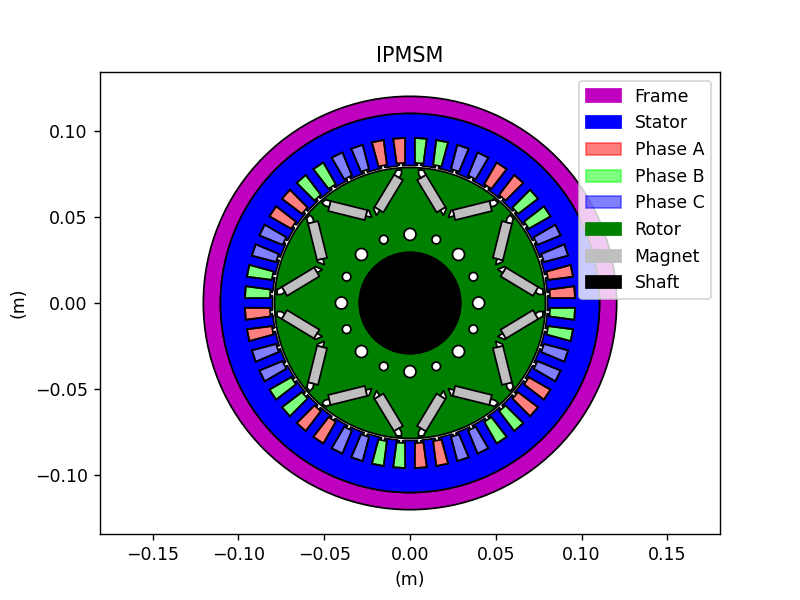

In [11]:
from pyleecan.Classes.MachineIPMSM import MachineIPMSM

%matplotlib notebook
IPMSM_xxx = MachineIPMSM(
    name="IPMSM", 
    stator=stator, 
    rotor=rotor, 
    shaft=shaft, 
    frame=frame
)

IPMSM_xxx.save('../Data/Machine/IPMSM_from_tutorial.json')

im=IPMSM_xxx.plot()